*Теоретический материал:* https://youtu.be/T1UTAI7axbs?t=91

*Разбор данного раздела:* https://youtu.be/T1UTAI7axbs?t=5177

# Подключение библиотек и Google диска


In [ ]:
# Выполняю расчеты в локальной среде и без данной операции YOLO выдает ошибку в Конда
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ZeroPadding2D, Add, UpSampling2D, Concatenate, Dropout, Lambda, LeakyReLU, ReLU # Стандартные слои Keras
from tensorflow.keras.regularizers import l2 # Регуляризатор l2
from tensorflow.keras.optimizers import Adam # Оптимизатор Adam
from tensorflow.keras.models import Model # Абстрактный класс Model
from PIL import Image, ImageDraw, ImageFont # Модули работы с изображениями
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb # Модули конвертации между RGB и HSV
# from google.colab import files # Модуль работы с файловой системой google

import tensorflow.keras.backend as K # бэкенд Keras
import math # Импортируем модуль math
import pandas as pd # Пандас для работы с csv
import tensorflow as tf # TensorFlow
import numpy as np # numpy массивы
import matplotlib.pyplot as plt # графики
import os # модуль работы с файловой системой
import time # модуль работы со временем
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
from google.colab import drive # подключаем гугл драйв диск для загрузки файлов
drive.mount('/content/drive')

# LIGHT

постарался сделать функцию более универсальной, поэтому помимо картинки на вход можно задавать:
- сохраненные веса, для загрузки в модель для предикта
- можно выбирать: отображать все наиболее вероятные баундинг боксы или уже после применения Non-max Suppression (добавил эту опцию из-за того что в задании двусмысленно сказано "со всеми найденными bounding_box.")
- будем анализировать только те баундинг боксы, в которых вероятность
  обнаружения объекта выше  параметра box_limit

Кроме этого модель анализирует все уровни анкоров, а не только нулевой как в ноутбуке с вебинара, чтобы можно было применять функции не только к датасету с самолетами.

In [ ]:
def yolo3_predict(pictPath, model_weight, 
                  withSuppress=True, box_limit=0.7):
  '''
  функция по обнаружению объектов на фотографии по модели YOLOv3
  Принимает на вход:
  - pictPath: путь к картинке, на которой необходимо обнаружить объект
  - model_weight: путь к обученной модели
  - withSuppress: если True, то вовзращается BoundingBox после применения алгоритма Non-max Suppression,
      если false, то возвращаются все наиболее вероятные bounding box, на которых найден объект
  - box_limit: будем анализировать только те баундинг боксы, в которых вероятность
  обнаружения объекта выше этого параметра

  returns: изображение с boundingBox обнаруженного объекта. Количество боксов зависит
   от параметров withSuppress и maxBoxes
  '''

  def sigmoid(x):
    return 1/(1+np.exp(-x))

  def non_max_suppression_fast(boxes, scores, overlapThresh):	
    if len(boxes) == 0: # Если нет ни одного бокса
      return []

    pick = [] # Индексы возвращаемых боксов
    
    x1 = boxes[:,0] # координаты x левыъ верхних углов
    y1 = boxes[:,1] 
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(scores)
    
    while len(idxs) > 0:
      last = len(idxs) - 1
      i = idxs[last]
      pick.append(i)
      
      xx1 = np.maximum(x1[i], x1[idxs[:last]])
      yy1 = np.maximum(y1[i], y1[idxs[:last]])
      xx2 = np.minimum(x2[i], x2[idxs[:last]])
      yy2 = np.minimum(y2[i], y2[idxs[:last]])
      
      w = np.maximum(0, xx2 - xx1 + 1)
      h = np.maximum(0, yy2 - yy1 + 1)
      
      overlap = (w * h) / area[idxs[:last]]
      idxs = np.delete(idxs, np.concatenate(([last],
                                            np.where(overlap > overlapThresh)[0])))
    
    return boxes[pick].astype("int"), scores[pick]


  model_YOLO = create_YOLOv3(Input(shape=(416, 416, 3)), 9//3)
  model_YOLO.load_weights(model_weight)
  print ('{} загружены.'.format(model_weight))

  import colorsys 
  hsv_tuples = [(x / len(name_classes), 1., 1.) for x in range(len(name_classes))]
  colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
  colors = list(map(lambda x:(int(x[0]*255), int(x[1]*255), int(x[2]*255)), colors))
  np.random.seed(43)
  np.random.shuffle(colors)
  np.random.seed(None)

  model_image_size = (416,416) 
  image = Image.open(pictPath) 

  iw, ih = image.size
  w, h = (416, 416)
  scale = min(w / iw, h / ih)
  nw = int(iw * scale)
  nh = int(ih * scale)
  image_for_predict = image.resize((nw, nh), Image.BICUBIC)
  new_image = Image.new('RGB', (416,416), (128, 128, 128))
  new_image.paste(image_for_predict, ((w - nw) // 2, (h - nh) // 2))
  image_for_predict = new_image 
  image_for_predict = np.array(image_for_predict) / 255.
  image_for_predict = image_for_predict.reshape(1, 416, 416, 3)

  predict = model_YOLO.predict(image_for_predict)
  num_layers = len(predict) 
  anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] 
  input_shape = np.array(predict[0].shape[1:3]) * 32  
  image_shape = np.array([image.size[1], image.size[0]])

  _boxes_out = []
  _scores_out = []
  classes_out = []
  for level_anchor in range(3):
    num_anchors = len(anchors[anchor_mask[level_anchor]]) 
    
    anchors_tensor = np.reshape(anchors[anchor_mask[level_anchor]], (1,1,1,num_anchors,2))
    grid_shape = predict[level_anchor].shape[1:3] 
    grid = [] 
    grid_row = [] 
    for i in range(grid_shape[0]):
      for j in range(grid_shape[1]):
        grid_row.append([j , i])
      grid.append(grid_row) 
      grid_row = []
    grid = np.array(grid) 
    grid = np.expand_dims(grid, axis=2)
    feats = np.reshape(predict[level_anchor], (-1, grid_shape[0], grid_shape[1], num_anchors, num_classes+5))
    xy_param = feats[..., :2] 
    box_xy = (sigmoid(xy_param) + grid)/grid_shape[::-1] 

    wh_param = feats[..., 2:4] 
    box_wh = np.exp(wh_param) * anchors_tensor / input_shape[::-1] 

    conf_param = feats[..., 4:5] 
    box_confidence = sigmoid(conf_param) 

    class_param = feats[...,5:] 
    box_class_probs = sigmoid(class_param)

    box_yx = box_xy[..., ::-1].copy()
    box_hw = box_wh[..., ::-1].copy()

    new_shape = np.round(image_shape * np.min(input_shape/image_shape)) 
    offset = (input_shape-new_shape)/2./input_shape 
    scale = input_shape/new_shape  
    box_yx = (box_yx - offset) * scale 
    box_hw *= scale

    box_mins = box_yx - (box_hw / 2.) 
    box_maxes = box_yx + (box_hw / 2.) 
    _boxes =  np.concatenate([
        box_mins[..., 0:1], 
        box_mins[..., 1:2], 
        box_maxes[..., 0:1], 
        box_maxes[..., 1:2] 
    ], axis=-1)

    _boxes *= np.concatenate([image_shape, image_shape])
    _box_scores = box_confidence * box_class_probs 
    _boxes_reshape = np.reshape(_boxes, (-1, 4)) 
    _box_scores_reshape = np.reshape(_box_scores, (-1, num_classes))

    mask = _box_scores_reshape >= box_limit

    _boxes_out_lev = _boxes_reshape[mask[:,0]]
    _scores_out_lev = _box_scores_reshape[:, 0][mask[:,0]] 
    classes_out_lev = np.ones_like(_scores_out_lev,'int32') * 0
    for bx in _boxes_out_lev:
      _boxes_out.append(bx)
    for sc in _scores_out_lev:
      _scores_out.append(sc)
    for cl in classes_out_lev:
      classes_out.append(cl)

  _boxes_out = np.array(_boxes_out)
  _scores_out = np.array(_scores_out)
  classes_out = np.array(classes_out)

  font = ImageFont.truetype(font=path + 'font.otf',
                    size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
  thickness = (image.size[0] + image.size[1]) // 300

  image_pred = image.copy()


  if not withSuppress:
    
    for i, c in reversed(list(enumerate(classes_out))):
      print(1)
      draw = ImageDraw.Draw(image_pred)
      predicted_class = name_classes[c]
      box = _boxes_out[i]
      score = _scores_out[i]

      label = '{} {:.2f}'.format(predicted_class, score)
      label_size = draw.textsize(label, font)

      top, left, bottom, right = box
      top = max(0, np.floor(top + 0.5).astype('int32'))
      left = max(0, np.floor(left + 0.5).astype('int32'))
      bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
      right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
      print(label, (left, top), (right, bottom))

      if top - label_size[1] >= 0:
          text_origin = np.array([left, top - label_size[1]])
      else:
          text_origin = np.array([left, top + 1])
      
      for i in range(thickness):
          draw.rectangle(
              [left + i, top + i, right - i, bottom - i],
              outline=colors[c])
      draw.rectangle(
          [tuple(text_origin), tuple(text_origin + label_size)],
          fill=colors[c])
      draw.text(text_origin, label, fill=(0, 0, 0), font=font)
      del draw

    plt.imshow(image_pred)
  
  else:
    new_boxes, new_scores = non_max_suppression_fast(_boxes_out, _scores_out, 0.15)
    new_classes = np.ones_like(new_scores,'int32') * 0


    
    for i, c in reversed(list(enumerate(new_classes))):
      draw = ImageDraw.Draw(image_pred)
      predicted_class = name_classes[c]
      box = new_boxes[i]
      score = new_scores[i]

      label = '{} {:.2f}'.format(predicted_class, score)
      label_size = draw.textsize(label, font)

      top, left, bottom, right = box
      top = max(0, np.floor(top + 0.5).astype('int32'))
      left = max(0, np.floor(left + 0.5).astype('int32'))
      bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
      right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
      print(label, (left, top), (right, bottom))

      if top - label_size[1] >= 0:
          text_origin = np.array([left, top - label_size[1]])
      else:
          text_origin = np.array([left, top + 1])
      
      for i in range(thickness):
          draw.rectangle(
              [left + i, top + i, right - i, bottom - i],
              outline=colors[c])
      draw.rectangle(
          [tuple(text_origin), tuple(text_origin + label_size)],
          fill=colors[c])
      draw.text(text_origin, label, fill=(0, 0, 0), font=font)
      del draw
    # plt.imshow(image_pred)

  return image_pred

# PRO

В данном ноутбуке оставил только уже итоговое обучение модели на полном наборе данных.
Пробы на урезанном наборе вынес в отдельный ноутбук, чтобы не засорять большим количество кода этот ноутбук. Посмотреть эксперименты можно здесь:

https://colab.research.google.com/drive/1YbcqP8sdLD7wzPTqsMEVXj-wr6njnj0e?usp=sharing

В целом обучение на меньшем наборе данных схоже с обучением на полном наборе: графики ошибок имеют примерно одинаковый вид падающей тенденции с отдельными разовыми выбрасами. Обучение модели на меньшем наборе показывает примерно такую же итоговую ошибку. Что подтверждает гипотезу, согласно которой можно проводить эксперименты на меньшем наборе, транслируя итоги на полный набор.

Итого лучшие результаты экспериментов показали изменения:
- прикрученный callback, сохраняющий лучшие результаты обучения. Позволяет модели обучаться быстрее
- уменьшенная аугментация. Убрал масштабируемость, уменьшил  освещенность, экспозицию, гамму изображения
- поменял функцию активации у свертков с LeakyRelu на Relu
- увеличил размеры анкоров ( в основном у нулевого уровня). Данное изменение подходит под конкретно этот датасет с самолетами, так как болшинство фотографий содержат крупное изображение самолетов
+ добавил дополнительные 500 шагов обучения

В итоге на маленьком наборе данных достиг показателей ошибки:
- 1.91 на обучающем наборе
- 1.5 на тестовом

Эти же изменения привели к значениям ошибки на полном наборе:
- 2.0762 на обучающей выборке и 
- 1.99 на тестовой


## Глобальные параметры

In [ ]:
path = 'Documents/ДЗ/31 Object detection/' # Путь к директории на диске, где находятся изображения
name_classes = ['Самолеты'] # Названия классов
num_classes = len(name_classes) # Количество классов
input_shape = (416, 416) # Размерность входного изображения для модели YOLO

# Массив используемых анкоров (в пикселях). Используетя по 3 анкора на каждый из 3 уровней сеток
# данные значения коррелируются с размерностью входного изображения input_shape
anchors = np.array([[10, 13], [16, 30], [33, 23], [30, 61], [62, 45], [59, 119], [116, 90], [156, 198], [373, 326]]) 
num_anchors = len(anchors) # Сохраняем количество анкоров

In [ ]:
path = '/content/drive/My Drive/Базы/Самолеты/' # Путь к директории на диске, где находятся изображения
name_classes = ['Самолеты'] # Названия классов
num_classes = len(name_classes) # Количество классов
input_shape = (416, 416) # Размерность входного изображения для модели YOLO

# Массив используемых анкоров (в пикселях). Используетя по 3 анкора на каждый из 3 уровней сеток
# данные значения коррелируются с размерностью входного изображения input_shape
anchors = np.array([[10, 13], [16, 30], [33, 23], [30, 61], [62, 45], [59, 119], [116, 90], [156, 198], [373, 326]]) 
num_anchors = len(anchors) # Сохраняем количество анкоров

## Создание модели

### Функции

*Разбор данного раздела:* https://youtu.be/T1UTAI7axbs?t=5304

In [ ]:
checkpoint_filepath = 'Documents/ДЗ/31 Object detection/my saves/short/full.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
'''
    Функция создания полной модели
        Входные параметры:       
          input_shape - размерность входного изображения для модели YOLO
          num_anchors - общее количество анкоров   
          use_weights - использовать ли предобученные веса         
          weights_path - путь к сохраненным весам модели  
'''
def create_model(
        input_shape,
        num_anchors,
        use_weights = False, 
        weights_path = 'yolo.h5'        
        ):
    w, h = input_shape # Получаем ширину и высоту входного изображения
    inputs = Input(shape = (w, h, 3)) # Создаем входной слой модели, добавляя размерность для глубины цвета
    
    # Создаем три входных слоя y_true с размерностями ((None, 13, 13, 3, 6), (None, 26, 26, 3, 6) и (None, 52, 52, 3, 6))
    # 2 и 3 параметры (13, 13) указывают размерность сетки, на которую условно будет разбито исходное изображение
    # каждый уровень сетки отвечает за обнаружение объектов различных размеров (13 - крупных, 26 - средних, 52 - мелких)
    # 4 параметр - количество анкоров на каждый уровень сетки
    # 5 параметр - 4 параметра описывающие параметры анкора (координаты центра, ширина и высота) + вероятность обнаружения объекта + OHE номер класса
    y_true = [Input (shape = (w // 32, h // 32, num_anchors // 3, num_classes + 5))] # Уровень сетки 13х13 (416/32)
    y_true.append (Input (shape = (w // 16, h // 16, num_anchors // 3, num_classes + 5))) # Уровень сетки 26х26 (416/26)
    y_true.append (Input (shape = (w // 8, h // 8, num_anchors // 3, num_classes + 5))) # Уровень сетки 52х52 (416/8)
    
    model_yolo = create_YOLOv3(inputs, num_anchors // 3) # Создаем модель YOLOv3
    print ('Создана модель YOLOv3. Количество классов: {}.'.format(num_classes)) # Выводим сообщение о создании модели
    
    # Если установлен флаг загрузки весов
    if use_weights:
        model_yolo.load_weights(weights_path, by_name = False, skip_mismatch = False) # Загружаем предобученные веса
        print ('Загружены веса из файла {}.'.format(weights_path)) # Выводим сообщение о загруженных весах
        
    # Создаем выходной слой Lambda (выходом которого будет значение ошибки модели)
    # На вход слоя подается:
    #   - model_yolo.output (выход модели model_yolo (то есть то, что посчитала сеть))
    #   - y_true (оригинальные данные из обучающей выборки)
    outputs = Lambda(yolo_loss, output_shape = (1,), name = 'yolo_loss', arguments = {'num_anchors' : num_anchors}) ([*model_yolo.output, *y_true])
    
    return Model([inputs, *y_true], outputs) # Возвращаем модель

In [ ]:
'''
Функция создания модели YOLOv3
    Входные параметры:
          inputs - Входной слой модели
          num_sub_anchors - количество анкоров в каждом уровне сеток
'''
def create_YOLOv3(
        inputs,
        num_sub_anchors
        ):
    #--------------------
    # Базовая часть модели YOLOv3
    #--------------------
    
    # Состоит из Conv2D-слоев и Residual-блоков. Residual-блок - это блок использующий информацию из предыдущих слоев.
    # С помощью слоя Add (Суммируется текущий слой и один из предыдущих), что позволяет избежать проблему потери информации
    # Количество resedual блоков и архитектура сети взята из документации YOLOv3
    x = ConvBL (inputs, 32, (3, 3)) # Добавляем каскад из трех слоев (Conv2D, BatchNormalization и Leaky)
    x = resblock (x, 64, 1) # Добавляем 1 resedual-блок с 64 нейронами
    x = resblock (x, 128, 2) # Добавляем 2 resedual-блока с 128 нейронами
    x = resblock (x, 256, 8) # Добавляем 8 resedual-блоков с 256 нейронами
    x = resblock (x, 512, 8) # Добавляем 8 resedual-блоков с 512 нейронами
    x = resblock (x, 1024, 4) # Добавляем 4 resedual-блоков с 1024 нейронами
    base_model = Model(inputs, x) # Создаем базовую часть модели YOLOv3
    
    #--------------------
    # Detection часть модели YOLOv3
    #--------------------
    
    # Выделяем три выхода сети, соответсвующих различным уровням сетки
    
    
    # 13 x 13 (обнаружение больших объектов)
    x = ConvBL(base_model.output, 512, (1, 1))    
    x = ConvBL(x, 1024, (3, 3))
    x = ConvBL(x, 512, (1, 1))
    x = ConvBL(x, 1024, (3, 3))
    x = ConvBL(x, 512, (1, 1))
    
    # Выделяем первый выход модели, соответствующий размерности 13 х 13
    y1 = ConvBL(x, 1024, (3,3))
    y1 = Conv2D(num_sub_anchors * (num_classes + 5), (1, 1), padding = 'same', kernel_regularizer = l2(5e-4)) (y1)
    
    
    # 26x26 (обнаружение средних объектов)
    
    # Размерность текущего выхода сети равна 13 х 13. Необходимо увеличить ее до 26 x 26 и
    # объеденить со 152-ым слоем (размерностью 26 x 26)
    x = ConvBL(x, 256, ( 1, 1)) 
    x = UpSampling2D(2) (x) # Увеличиваем размерность до 26 на 26, использую UpSampling
    x = Concatenate()([x,base_model.layers[152].output])
    
    # Добавляем 5 блоков ConvBL
    x = ConvBL(x, 256, (1, 1))  
    x = ConvBL(x, 512, (3, 3))
    x = ConvBL(x, 256, (1, 1))
    x = ConvBL(x, 512, (3, 3))
    x = ConvBL(x, 256, (1, 1))
    
    # Выделяем второй выход модели, соответствующий размерности 26 х 26
    y2 = ConvBL(x, 512, (3, 3))
    y2 = Conv2D(num_sub_anchors * (num_classes + 5), (1, 1), padding = 'same', kernel_regularizer = l2(5e-4)) (y2)
    
    # 52 x 52 (обнаружение маленьких объектов)
    
    # Размерность текущего выхода сети равна 26 х 26. Необходимо увеличить ее до 52 x 52 и
    # объеденить со 92-ым слоем (размерностью 52 x 52)
    x = ConvBL(x, 128, ( 1, 1)) 
    x = UpSampling2D(2) (x)  # Увеличиваем размерность до 52 на 52, использую UpSampling
    x = Concatenate()([x,base_model.layers[92].output])
    
    # Добавляем 5 блоков ConvBL
    x = ConvBL(x, 128, (1, 1))  
    x = ConvBL(x, 256, (3, 3))
    x = ConvBL(x, 128, (1, 1))
    x = ConvBL(x, 256, (3, 3))
    x = ConvBL(x, 128, (1, 1))
    
    # Выделяем третий выход модели, соответствующий размерности 52 х 52
    y3 = ConvBL(x, 256, (3, 3))
    y3 = Conv2D(num_sub_anchors * (num_classes + 5), (1, 1), padding = 'same', kernel_regularizer = l2(5e-4)) (y3)
    
    return Model(inputs, [y1, y2, y3]) # Возвращаем модель

In [ ]:
''' Функция создания Residual блока.
    Входные параметры:
          inputs - Стартовый слой, к которому добавляется Res-блок
          num_filters - количество нейронов
          num_blocks  - количество блоков 
 '''
def resblock(
        inputs,
        num_filters,
        num_blocks
        ):
    x = ZeroPadding2D(((1, 0), (1, 0)))(inputs) # Увеличиваем размерность на один шаг влево и вверх
    x = ConvBL(x, num_filters, (3, 3), strides=(2, 2)) # Добавляем блок ConvBL
    for i in range(num_blocks): # Пробегаем в цикле num_blocks-раз (суммируя слои с помощью Add())
        y = ConvBL(x, num_filters // 2, (1, 1))
        y = ConvBL(y, num_filters, (3, 3))
        x = Add() ([x, y])
    return x # Возвращаем слой

In [ ]:
''' Функция создания блока Conv2D, BatchNormalization, LeakyRelu
    Входные параметры:
          inputs - Стартовый слой, к которому добавляется Res-блок
          args - массив неименованных параметров
          kwargs  - массив именованных параметров
 '''
def ConvBL(
        inputs,
        *args,
        **kwargs
        ): 
    new_kwargs = {'use_bias': False} # создаем новый массив именованных параметров, добавляя параметр use_bias
    new_kwargs['kernel_regularizer'] = l2(5e-4) # добавляем параметр kernel_regularizerpadding
    new_kwargs['padding'] = 'valid' if kwargs.get('strides') == (2, 2) else 'same' # добавляем параметр  padding
    new_kwargs.update(kwargs) # Добавляем уже имеющиеся в kwargs gfhfvtnhs
    x = Conv2D(*args, **new_kwargs) (inputs) # Добавляем Conv2D слой
    x = BatchNormalization() (x) # Добавляем слой BatchNormalization
    x = LeakyReLU(alpha=0.1) (x) # Добавляем слой LeakyRelu
    return x

In [ ]:
'''
Функция подсчета ошибки.
    Входные параметры:
        inputs - Входные данные
        num_anchors - общее количество анкоров                    
'''
def yolo_loss(
      inputs,
      num_anchors
      ):
    ignore_thresh = .5 # Порог вероятности обнаружения объекта
    num_layers = num_anchors // 3 # Подсчитываем количество анкоров на каждом уровне сетки
    y_pred = inputs[:num_layers] # Из входных данных выцепляем посчитанные моделью значения
    y_true = inputs[num_layers:] # Из входных данных выцепляем эталонные значения
    anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]] # Задаем маску анкоров для каждого уровня сеток
   
    
    # Получаем размерность входного изображения ( (13 х 13) * 32 = (416 х 416)) и приводим к типу элемента y_true[0]
    input_shape = K.cast(K.shape(y_pred[0])[1:3] * 32, K.dtype(y_true[0])) 
    
    # Получаем двумерный массив, соответствующий размерностям сеток ((13, 13), (26, 26), (52, 52))
    grid_shapes = [K.cast(K.shape(y_pred[l])[1:3], K.dtype(y_true[0])) for l in range(num_layers)]
    
    loss = 0 # Значение ошибки
    
    # Считываем количество элементов
    m = K.shape(y_pred[0])[0] # Размер пакета
    batch_size = K.cast(m, K.dtype(y_pred[0])) # Преобразуем к типу y_pred[0]
    
    for l in range(num_layers): # Пробегаем по всем трем уровням сеток
        # Получаем маску для сетки l-го уровня по вероятности определения объекта (5-ый параметр в списке общих параметров). 
        # В массиве object_mask будут значения, которые соответствуют только вероятности обнаружения объекта
        object_mask = y_true[l][..., 4:5] # Вернется набор данных вида: ([0][0][0][0]...[1]...[0])
        
        # Получаем аналогичную выборку для сетки l-го уровня с OHE (где записана позиция нашего класса)
        # В массиве true_class будут значения, которые соответсвуют только OHE представлению класса ядля данного уровня анкоров
        true_class = y_true[l][..., 5:] # Вернется набор данных вида: ([0][0][0][0]...[1]...[0])
        
        num_sub_anchors = len(anchors[anchor_mask[l]]) # Получаем количество анкоров для отдельного уровян сетки (3)
        
        # Решейпим анкоры отдельного уровня сетки и записываем в переменную anchors_tensor
        anchors_tensor = K.reshape(K.constant(anchors[anchor_mask[l]]), [1, 1, 1, num_sub_anchors, 2])
        
        # Создаем двумерный массив grid со значениями [[[0, 0] , [0, 1] , [0, 2] , ... , [0, k]], 
        #                                             [[1, 0] , [1, 1] , [1, 2] , ... , [1 ,k]],
        #                                             ...
        #                                             [[k, 0] , [k, 1] , [k, 2] , ... , [k, k]]]
        # где k - размерность сетки. Массив хранит индексы ячеек сетки
        grid_shape = K.shape(y_pred[l])[1:3] # Получаем ширину и высоту сетки
        grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),[1, grid_shape[1], 1, 1]) # Создаем вертикальную линию
        grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),[grid_shape[0], 1, 1, 1]) # Создаем горизонтальную линию
        grid = K.concatenate([grid_x, grid_y]) # Объединяем 
        grid = K.cast(grid, K.dtype(y_pred[l])) # Приводим к типу y_pred[l]
        
        # Решейпим y_pred[l]
        feats = K.reshape(y_pred[l], [-1, grid_shape[0], grid_shape[1], num_sub_anchors, num_classes + 5]) 
        
        # Считаем ошибку в определении координат центра объекта
        # Получаем координаты центра объекта из спредиктенного значения
        pred_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[::-1], K.dtype(feats)) 
        # Производим обратные вычесления для оригинальных значений из y_true для координат центра объекта
        true_xy = y_true[l][..., :2] * grid_shapes[l][::-1] - grid  # Реальные координаты центра bounding_box
        box_loss_scale = 2 - y_true[l][...,2:3] * y_true[l][...,3:4] # чем больше бокс, тем меньше ошибка
        # binary_crossentropy для истинного значения и спредиктенного (obect_mask для подсчета только требуемого значения)
        xy_loss = object_mask * box_loss_scale * K.binary_crossentropy(true_xy, feats[...,0:2], from_logits=True)

        # Считаем ошибку в определении координат ширины и высоты
        # Получаем значения ширины и высоты изображения из спредиктенного значения   
        pred_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[::-1], K.dtype(feats)) 
        # Производим обратные вычесления для оригинальных значений из y_true для ширины и высоты объекта
        true_wh = K.log(y_true[l][..., 2:4] / anchors[anchor_mask[l]] * input_shape[::-1]) 
        # Оставляем значение высоты и ширины только у тех элементов, где object_mask = 1
        true_wh = K.switch(object_mask, true_wh, K.zeros_like(true_wh)) 
        # Считаем значение ошибки в определении высоты и ширины
        wh_loss = object_mask * box_loss_scale * 0.5 * K.square(true_wh-feats[...,2:4])
        
        # Объединяем значения в один  массив
        pred_box = K.concatenate([pred_xy, pred_wh]) 
        
        # Считаем ошибку в определении обнаружения какого-либо класса
        # Для этого вначале надо отсечь все найденные объекты, вероятность которых меньше установленного значения ignore_thresh
        
        # Определяем массив, который будет хранить данные о неподходящих значениях
        ignore_mask = tf.TensorArray(K.dtype(y_true[0]), size=1, dynamic_size=True) 
        object_mask_bool = K.cast(object_mask, 'bool') # Приводим тип object_mask к типу 'bool'
        
        # Функция, определяющая данные, которые требуется игнорировать
        # Пробегаем по всем элементам пакета (b<m)
        # Получаем параметры реального bounding_box для текущей ячейки
        # Считаем IoU реального и спредиктенного
        # В зависимости от best_iou < ignore_thresh помечаем его как верно распознанный или неверено
        def loop_body(
                b,
                ignore_mask
                ):
            # в true_box запишутся первыые 4 параметра (центр, высота и ширина объекта) того элемента, значение которого в object_mask_bool равно True
            true_box = tf.boolean_mask(y_true[l][b,...,0:4], object_mask_bool[b,...,0]) 
            # Подсчитываем iou для спредиктенной ограничивающей рамки (pred_box) и оригинальной (true_box)
            iou = calc_iou(pred_box[b], true_box) 
            # Находим лучшую ограничивающую рамку
            best_iou = K.max(iou, axis=-1) 
            # Записываем в ignore_mask true или false в зависимости от (best_iou < ignore_thresh)
            ignore_mask = ignore_mask.write(b, K.cast(best_iou < ignore_thresh, K.dtype(true_box))) 
            return b+1, ignore_mask # Увеличиваем счетчик на еденицу и возвращаем ignore_mask
        
        # Пробегаем в цикле по всем элементам в пределах значения m (m = batch size)
        _, ignore_mask = tf.while_loop(lambda b,*args: b<m, loop_body, [0, ignore_mask]) 
        ignore_mask = ignore_mask.stack() # Приводим ignore_mask к тензору
        ignore_mask = K.expand_dims(ignore_mask, -1) # Добавляем еще одну размерность в конце ignore_mask
                 
        # Считаем значение ошибки
        # 1 компонента - для значений, которые были верно спредиктены
        # 2 компонентя - для значения, которые были неверно спредиктены
        confidence_loss = (
            object_mask * K.binary_crossentropy(object_mask, feats[...,4:5], from_logits=True) +
            (1-object_mask) * K.binary_crossentropy(object_mask, feats[...,4:5], from_logits=True) * ignore_mask
            )
        
        # Считаем ошибку в определении класса объекта
        class_loss = object_mask * K.binary_crossentropy(true_class, feats[...,5:], from_logits=True)
    
        # Считаем суммарную ошибку
        xy_loss = K.sum(xy_loss) / batch_size
        wh_loss = K.sum(wh_loss) / batch_size
        confidence_loss = K.sum(confidence_loss) / batch_size
        class_loss = K.sum(class_loss) / batch_size
        loss += xy_loss + wh_loss + confidence_loss + class_loss
                
    return loss # Возвращаем значение ошибки   

In [ ]:
'''
    Функция подсчета IoU
'''
def calc_iou(input1, input2):
    input1 = K.expand_dims(input1, -2) # Добавляем одну размерность
    xy1 = input1[..., :2] # Получаем координаты x,y центра 
    wh1 = input1[..., 2:4] # Получаем значения высоты и ширины
    wh_half1 = wh1 / 2. # Делим значения высоты и ширины пополам
    top_left1 = xy1 - wh_half1 # Получаем значение, соответствующее верхнему левому углу
    right_bottom1 = xy1 + wh_half1 # Получаем значение, соотвествующее правому нижнему углу
    
    input2 = K.expand_dims(input2, 0) # Добавляем одну размерность
    xy2 = input2[..., :2] # Получаем координаты x,y центра 
    wh2 = input2[..., 2:4] # Получаем значения высоты и ширины
    wh_half2 = wh2 / 2. # Делим значения высоты и ширины пополам
    top_left2 = xy2 - wh_half2 # Получаем значение, соответствующее верхнему левому углу
    right_bottom2 = xy2 + wh_half2 # Получаем значение, соотвествующее правому нижнему углу
    
    intersect_mins = K.maximum(top_left1, top_left2) # Берем максимальные координаты из левых верхних углов
    intersect_maxes = K.minimum(right_bottom1, right_bottom2) # Берем Минимальные координаты координаты из правых нижних углов
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.) # Считаем ширину и высоту области пересечения
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1] # Считаем площадь области пересечения
    
    area1 = wh1[..., 0] * wh1[..., 1] # Считаем площадь первых элементов
    area2 = wh2[..., 0] * wh2[..., 1] # Считаем площадь вторых элементов
    
    return intersect_area / (area1 + area2 - intersect_area) # Возвращаем IoU
    

## Основной код

*Разбор данного раздела:* https://youtu.be/T1UTAI7axbs?t=7310

In [ ]:
# Создаем модель
model_YOLO = create_model(input_shape, num_anchors, use_weights=False, weights_path=path +'weights/YOLOv3__el1000__opt0.0001__ep0_100.h5')

Создана модель YOLOv3. Количество классов: 1.


In [ ]:
# Выводим входные размерности для модели
model_YOLO.input

[<KerasTensor: shape=(None, 416, 416, 3) dtype=float32 (created by layer 'input_9')>,
 <KerasTensor: shape=(None, 13, 13, 3, 6) dtype=float32 (created by layer 'input_10')>,
 <KerasTensor: shape=(None, 26, 26, 3, 6) dtype=float32 (created by layer 'input_11')>,
 <KerasTensor: shape=(None, 52, 52, 3, 6) dtype=float32 (created by layer 'input_12')>]

In [ ]:
# Выводим выходныую размерность модели
model_YOLO.output

<KerasTensor: shape=() dtype=float32 (created by layer 'yolo_loss')>

In [ ]:
# Выводим информацию о модели
model_YOLO.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 416, 416, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 416, 416, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

## Обучение модели

## Функции

*Разбор данного раздела:* https://youtu.be/T1UTAI7axbs?t=8057

In [ ]:
# Функция генерации данных
def data_generator(annotation_lines, batch_size, anchors, input_shape):
    n = len(annotation_lines) # Получаем количество элементов в словаре аннотаций
    i = 0 # Задаем начальный индекс
    while True:
        image_data = [] # Массив для хранения изображений 416х416
        box_data = [] # Массив для хранения bounding_box данных
        for b in range(batch_size): # Пробегаем по всему batch_size
            if i==0: # Если первая итерация цикла
                np.random.shuffle(annotation_lines) # Перемешиваем элементы
            image, box = augmentation(annotation_lines[i]) # Делаем аугментацию картинок и ограничивающих рамок
            image_data.append(image) # Добавляем полученную картинку в результирующий массив 
            box_data.append(box) # Добавляем полученную ограничивающую рамку в массив bounfing_box
            i = (i+1) % n # Обновляем значение индека (не превышая общего количества элементов)
        image_data = np.array(image_data) # Преобразуем в numpy
        box_data = np.array(box_data) # Преобразуем в numpy
        y_true = get_y(box_data, anchors, input_shape) # По значению ограничивающей рамки получаем y_true        
        yield [image_data, *y_true], np.zeros(batch_size) # Возвращаем порцию данных для обучения

In [ ]:
# Случайная аугментация изображения
def augmentation(data):
    # Словарь с параметрами аугментации
    params = {
        'jitter' : .3,
        'hue'    : .1,
        'sat'    : 1.5,
        'val'    : 1.5
    }
    
    data = data.split() # Сплитим входную строку словаря
    image = Image.open(path + data[0]) # Открываем изображение самолета
    width_i, height_i = image.size # Получаем ширину и высоту оригинального изображения
    widht_shape, height_shape = input_shape[:2] # Получаем ширину и высоту входного изображения для модели RetinaNet
    
    # Получаем координаты ограничивающей рамки
    box = np.array([np.array(list(map(lambda x: int(float(x)),box.split(',')))) for box in data[1:]])
    
    # Случайным образом масштабируем изображение
    new_ar = widht_shape / height_shape * rand(1 - params['jitter'], 1 + params['jitter']) / rand(1 - params['jitter'], 1 + params['jitter'])
    scale = rand(.65, 2) 
    if new_ar < 1:        
        nh = int(scale * height_shape)
        nw = int(nh * new_ar)
    else:
        nw = int(scale * widht_shape)
        nh = int(nw / new_ar)
    image = image.resize((nw, nh), Image.BICUBIC)
    
    # Преобразуем картинку к input_shape и размещаем случайным образом
    dx = int(rand(0, widht_shape - nw))
    dy = int(rand(0, height_shape - nh))
    new_image = Image.new('RGB', (widht_shape, height_shape), (128,128,128))
    new_image.paste(image, (dx, dy))
    image = new_image
    
    # С вероятностью 50% отображаем по горизонтале
    flip = rand() < .5
    if flip:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
    
    # Случайным образом меняем освещенность, экспозицию, гамму изображения
    hue1 = rand(-params['hue'], params['hue'])
    sat1 = rand(1, params['sat']) if rand() < .5 else 1 / rand(1, params['sat'])
    val1 = rand(1, params['val']) if rand() < .5 else 1 / rand(1, params['val'])
    x = rgb_to_hsv(np.array(image) / 255.)
    x[..., 0] += hue1
    x[..., 0][x[..., 0] > 1] -= 1
    x[..., 0][x[..., 0] < 0] += 1
    x[..., 1] *= sat1
    x[..., 2] *= val1
    x[x > 1] = 1
    x[x < 0] = 0
    image_data = hsv_to_rgb(x) # Получаем окончательный массив
    
    max_boxes = 4 # Устанавливаем максимальное количество рамок на изображении
    # Корректируем параметры ограничивающей рамки в соответсвии с проведенными выше преобразованиями
    box_data = np.zeros((max_boxes,5)) # Создаем массив из нулей размерностью (max_boxes, 5) 
    if len(box)>0:                
        # Ресайзим и перемещаем
        box[:, [0,2]] = box[:, [0,2]] * nw/width_i + dx
        box[:, [1,3]] = box[:, [1,3]] * nh/height_i + dy
        # Отражаем по горизонтале
        if flip: box[:, [0,2]] = widht_shape - box[:, [2,0]]
        box[:, 0:2][box[:, 0:2]<0] = 0
        # Ограничиваем, если вышли за пределы input_shape
        box[:, 2][box[:, 2] > widht_shape] = widht_shape
        box[:, 3][box[:, 3] > height_shape] = height_shape
        # Считаем высоту и ширину рамок и оставляем только те, значения которых больше 1
        box_w = box[:, 2] - box[:, 0] # xRight - xLeft
        box_h = box[:, 3] - box[:, 1] # yBottom - yTop
        box = box[np.logical_and(box_w > 1, box_h > 1)]
        if len(box) > max_boxes: # Оставляем только max_boxes рамок
            box = box[:max_boxes]
        box_data[:len(box)] = box # Записываем данные в box_data
    
    # Возвращаем изменные изображение и ограничивающую рамку
    return image_data, box_data # Возвращаем аугментированные изображение и bounding_box

In [ ]:
# Функция подсчета y
def get_y(true_boxes, anchors, input_shape):
    num_layers = len(anchors) // 3 # Получаем количество анкоров для каждого уровня сеток
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] # Задаем маску анкоров для каждого уровня

    true_boxes = np.array(true_boxes, dtype='float32') # Преобразуем bounding_box в numpy
    input_shape = np.array(input_shape, dtype='int32') # Преобразуем input_shape в numpy
    boxes_xy = (true_boxes[..., 0:2] + true_boxes[..., 2:4]) // 2 # Получаем координаты центра bounding_box (xRight+xLeft / 2)
    boxes_wh = true_boxes[..., 2:4] - true_boxes[..., 0:2] # Получаем ширину и высоту bounding_box (xRight - xLeft)
    true_boxes[..., 0:2] = boxes_xy / input_shape[::-1] # Получаем координаты центра bounding_box в относительных координатах
    true_boxes[..., 2:4] = boxes_wh / input_shape[::-1] # Получаем высоту и ширину bounding_box В относительных значениях

    m = true_boxes.shape[0] # Получаем количество элементов в batch_size
    grid_shapes = [input_shape//{0:32, 1:16, 2:8}[l] for l in range(num_layers)] # Создаем список из трех элементов ([13, 13], [26, 26], [52, 52])

    # Создаем 0-вые списки для y_true
    # y_true[0].shape = (None, 13, 13, 3, 6)
    # y_true[1].shape = (None, 26, 26, 3, 6)
    # y_true[2].shape = (None, 52, 52, 3, 6)
    y_true = [np.zeros((m,grid_shapes[l][0],grid_shapes[l][1],len(anchor_mask[l]),5+num_classes),
        dtype='float32') for l in range(num_layers)]

    anchors = np.expand_dims(anchors, 0) # Добавляем размерность

    # Параметры для IoU
    anchor_maxes = anchors / 2. 
    anchor_mins = -anchor_maxes
    valid_mask = boxes_wh[..., 0] > 0

    for b in range(m):
        wh = boxes_wh[b, valid_mask[b]] # Получаем ширину и высоту текущего bounding_box
        if len(wh)==0: continue # Выходим если она нулевая
        wh = np.expand_dims(wh, -2) # Добавляем размерность
        
        # Параметры для IoU
        box_maxes = wh / 2.
        box_mins = -box_maxes
        
        intersect_mins = np.maximum(box_mins, anchor_mins) 
        intersect_maxes = np.minimum(box_maxes, anchor_maxes)
        intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
        intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
        box_area = wh[..., 0] * wh[..., 1]
        anchor_area = anchors[..., 0] * anchors[..., 1]
        iou = intersect_area / (box_area + anchor_area - intersect_area)

        best_anchor = np.argmax(iou, axis=-1) # Находим лучшее значение iou для всех анкоров 

        for t, n in enumerate(best_anchor): 
            for l in range(num_layers):
                if n in anchor_mask[l]:
                    i = np.floor(true_boxes[b,t,0] * grid_shapes[l][1]).astype('int32')
                    j = np.floor(true_boxes[b,t,1] * grid_shapes[l][0]).astype('int32')
                    k = anchor_mask[l].index(n)
                    c = true_boxes[b,t, 4].astype('int32')
                    y_true[l][b, j, i, k, 0:4] = true_boxes[b,t, 0:4]
                    y_true[l][b, j, i, k, 4] = 1
                    y_true[l][b, j, i, k, 5+c] = 1
    return y_true

In [ ]:
# Получение координат ограничивающей рамки
def getXY(image):
    image_red = np.array(image)[:,:,0]  # Считываем красный канал изображения
    indexes = np.where(image_red > 20) # Получаем индексы пискселей красного цвета
    
    # Возвращаем координаты ограничивающей рамки [Xmin, Ymin, Xmax, Ymax]
    return [min(indexes[1]), min(indexes[0]), max(indexes[1]), max(indexes[0]) ]

# Создание словаря {Имя файла: параметры файла}
def get_dict():
    dictionary = {} # Создаем пустой словарь
    files = os.listdir(path + 'Segment/') # Получаем список файлов
    class_id = 0 # Задаем параметр номера класса (у нас всего один класс "Самолет")
    for f in files:
        image = Image.open(path + 'Segment/'+f) # Открываем сегментированное изображение
        xy = getXY(image) # Получаем координаты ограничивающей рамки
        key = f # Получаем ключ словаря (имя файла)
        
        # Записываем значение в словарь
        dictionary[key] = 'Самолеты/'+key+' ' +str (xy[0]) +',' + str(xy[1])+','+str(xy[2])+','+str(xy[3])+','+str(class_id)
    print ('Завершена обработка класса: ', name_classes[0]) # Выводим сообщение о заврешении обработки
        
    return dictionary # Возвращаем словарь

def get_dict_short():
  # функция для эксперемментов на маленькой базе
    dictionary = {} # Создаем пустой словарь
    files = os.listdir(path + 'Segment/')[0:200:2] # Получаем список файлов
    class_id = 0 # Задаем параметр номера класса (у нас всего один класс "Самолет")
    for f in files:
        image = Image.open(path + 'Segment/'+f) # Открываем сегментированное изображение
        xy = getXY(image) # Получаем координаты ограничивающей рамки
        key = f # Получаем ключ словаря (имя файла)
        
        # Записываем значение в словарь
        dictionary[key] = 'Самолеты/'+key+' ' +str (xy[0]) +',' + str(xy[1])+','+str(xy[2])+','+str(xy[3])+','+str(class_id)
    print ('Завершена обработка класса: ', name_classes[0]) # Выводим сообщение о заврешении обработки
        
    return dictionary # Возвращаем словарь


def rand(a=0, b=1):
    return np.random.rand()*(b-a) + a

## Подготовка данных

In [ ]:
# Создаем словарь аннотаций (Формат: Имя_файла Xmin,Ymin,Xmax,Ymax,class_id)
startTime = time.time() # Засекаем время старта процесса создания словаря
dictionary = get_dict() # Вызываем функцию создания словаря

# Выводим сообщение о создании словаря и время, потраченное на создание словаря
print ('Словарь аннотаций создан! Время создания словаря:'+str(round(time.time() - startTime)) +'сек')

Завершена обработка класса:  Самолеты
Словарь аннотаций создан! Время создания словаря:100сек


In [ ]:
print ('Количество изображений:', len(dictionary)) # Отображаем количество элементов в словаре

Количество изображений: 981


In [ ]:
dictionary_np = np.array(list(dictionary.values())) #Создаем numpy массив из значений словаря

# Выведем информацию из словаря и из его numpy представления
# print (dictionary['airplane_2.jpg'])
# print(dictionary_np[0])

In [ ]:
val_split = 0.1 # Коэфициент разделения на обучающую и проверочную выборку

# Перемешаем значения в массиве
np.random.seed(17)
np.random.shuffle(dictionary_np)
np.random.seed(None)

num_val = int(len(dictionary_np) * val_split) # Количество элементов проверочной выборки
num_train = len(dictionary_np) - num_val # Количество элементов обучающей выборки
print (num_val)
print (num_train)

98
883


# Измененные параметры: Меньше аугментации, Relu, большие анкоры

Перезадаем функции согласно тем изменениям, которые дали лучший прирост эффективности на маленькой выборке

аугментация уменьшена

In [ ]:
# Случайная аугментация изображения
def augmentation(data):
    # Словарь с параметрами аугментации
    params = {
        'jitter' : 0.,
        'hue'    : .1,
        'sat'    : 1.1,
        'val'    : 1.1
    }
    
    data = data.split() # Сплитим входную строку словаря
    image = Image.open(path + data[0]) # Открываем изображение самолета
    width_i, height_i = image.size # Получаем ширину и высоту оригинального изображения
    widht_shape, height_shape = input_shape[:2] # Получаем ширину и высоту входного изображения для модели RetinaNet
    
    # Получаем координаты ограничивающей рамки
    box = np.array([np.array(list(map(lambda x: int(float(x)),box.split(',')))) for box in data[1:]])
    
    # Случайным образом масштабируем изображение
    new_ar = widht_shape / height_shape * rand(1 - params['jitter'], 1 + params['jitter']) / rand(1 - params['jitter'], 1 + params['jitter'])
    scale = rand(.65, 2) 
    if new_ar < 1:        
        nh = int(scale * height_shape)
        nw = int(nh * new_ar)
    else:
        nw = int(scale * widht_shape)
        nh = int(nw / new_ar)
    image = image.resize((nw, nh), Image.BICUBIC)
    
    # Преобразуем картинку к input_shape и размещаем случайным образом
    dx = int(rand(0, widht_shape - nw))
    dy = int(rand(0, height_shape - nh))
    new_image = Image.new('RGB', (widht_shape, height_shape), (128,128,128))
    new_image.paste(image, (dx, dy))
    image = new_image
    
    # С вероятностью 50% отображаем по горизонтале
    flip = rand() < .5
    if flip:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
    
    # Случайным образом меняем освещенность, экспозицию, гамму изображения
    hue1 = rand(-params['hue'], params['hue'])
    sat1 = rand(1, params['sat']) if rand() < .5 else 1 / rand(1, params['sat'])
    val1 = rand(1, params['val']) if rand() < .5 else 1 / rand(1, params['val'])
    x = rgb_to_hsv(np.array(image) / 255.)
    x[..., 0] += hue1
    x[..., 0][x[..., 0] > 1] -= 1
    x[..., 0][x[..., 0] < 0] += 1
    x[..., 1] *= sat1
    x[..., 2] *= val1
    x[x > 1] = 1
    x[x < 0] = 0
    image_data = hsv_to_rgb(x) # Получаем окончательный массив
    
    max_boxes = 4 # Устанавливаем максимальное количество рамок на изображении
    # Корректируем параметры ограничивающей рамки в соответсвии с проведенными выше преобразованиями
    box_data = np.zeros((max_boxes,5)) # Создаем массив из нулей размерностью (max_boxes, 5) 
    if len(box)>0:                
        # Ресайзим и перемещаем
        box[:, [0,2]] = box[:, [0,2]] * nw/width_i + dx
        box[:, [1,3]] = box[:, [1,3]] * nh/height_i + dy
        # Отражаем по горизонтале
        if flip: box[:, [0,2]] = widht_shape - box[:, [2,0]]
        box[:, 0:2][box[:, 0:2]<0] = 0
        # Ограничиваем, если вышли за пределы input_shape
        box[:, 2][box[:, 2] > widht_shape] = widht_shape
        box[:, 3][box[:, 3] > height_shape] = height_shape
        # Считаем высоту и ширину рамок и оставляем только те, значения которых больше 1
        box_w = box[:, 2] - box[:, 0] # xRight - xLeft
        box_h = box[:, 3] - box[:, 1] # yBottom - yTop
        box = box[np.logical_and(box_w > 1, box_h > 1)]
        if len(box) > max_boxes: # Оставляем только max_boxes рамок
            box = box[:max_boxes]
        box_data[:len(box)] = box # Записываем данные в box_data
    
    # Возвращаем изменные изображение и ограничивающую рамку
    return image_data, box_data # Возвращаем аугментированные изображение и bounding_box

в сверточных блоках применил RelU, вместо Leaky Relu

In [ ]:
def ConvBL(
        inputs,
        *args,
        **kwargs
        ): 
    new_kwargs = {'use_bias': False} # создаем новый массив именованных параметров, добавляя параметр use_bias
    new_kwargs['kernel_regularizer'] = l2(5e-4) # добавляем параметр kernel_regularizerpadding
    new_kwargs['padding'] = 'valid' if kwargs.get('strides') == (2, 2) else 'same' # добавляем параметр  padding
    new_kwargs.update(kwargs) # Добавляем уже имеющиеся в kwargs gfhfvtnhs
    x = Conv2D(*args, **new_kwargs) (inputs) # Добавляем Conv2D слой
    x = BatchNormalization() (x) # Добавляем слой BatchNormalization
    x = ReLU() (x) # Добавляем слой LeakyRelu
    return x

немного увеличил размер анкоров

In [ ]:
anchors = np.array([[20, 23], [26, 40], [43, 43], [40, 72], [65, 55], [69, 129], [135, 90], [195, 156], [326, 373]]) 
num_anchors = len(anchors) # Сохраняем количество анкоров

### lr_value = 1e-3

#### Первые 100 эпох

In [ ]:
# Создаем модель
model_YOLO = create_model(input_shape, num_anchors, use_weights=False, weights_path=path +'weights/YOLOv3__el1000__opt0.0001__ep0_100.h5')
lr_value = 1e-3 # Задаем размер шага обучения

# Компилируем модель
model_YOLO.compile(optimizer=Adam(lr=lr_value), loss={'yolo_loss': lambda y_true, y_pred: y_pred})

Создана модель YOLOv3. Количество классов: 1.


In [ ]:
startTime = time.time() # Засекаем время начала процесса обучения
batch_size = 2 #Задаем размер пакета

# Запускаем процесс обучения на 100 эпохах
history = model_YOLO.fit_generator(data_generator(dictionary_np[:num_train], batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, num_train//batch_size),
                    validation_data = data_generator(dictionary_np[num_train:], batch_size, anchors, input_shape),
                    validation_steps = max (1, num_val//batch_size),
                    epochs = 100,
                    verbose = 1,
                    initial_epoch = 0,
                    callbacks = [model_checkpoint_callback]
                    )


# Сохраним значения ошибок в csv
loss = np.array(history.history['loss']) # Получаем значения ошибки на обучающей выборке
val_loss = np.array(history.history['val_loss']) # Получаем значения ошибки на проверочной выборке
pd.DataFrame(loss).to_csv(path+'csv/YOLO/loss__el1000_opt0.001__ep0_100.csv') # Сохраняем обучающую выборку
pd.DataFrame(val_loss).to_csv(path+'csv/YOLO/valloss__el1000_opt0.001__ep0_100.csv') # Сохраняем проверочную выборку

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') # Отображаем время, потраченное на процесс обучения

C:\Users\Vlaso\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
441/441 [==============================] - 108s 204ms/step - loss: 751.7039 - val_loss: 40.4206
Epoch 2/100
441/441 [==============================] - 88s 199ms/step - loss: 24.6675 - val_loss: 114.1803
Epoch 3/100
441/441 [==============================] - 93s 210ms/step - loss: 19.7195 - val_loss: 103.5246
Epoch 4/100
441/441 [==============================] - 85s 192ms/step - loss: 18.2326 - val_loss: 176.3932
Epoch 5/100
441/441 [==============================] - 83s 189ms/step - loss: 16.6831 - val_loss: 22.6206
Epoch 6/100
441/441 [==============================] - 83s 189ms/step - loss: 25.9439 - val_loss: 23.7008
Epoch 7/100
441/441 [==============================] - 83s 188ms/step - loss: 22.2830 - val_loss: 21.0842
Epoch 8/100
441/441 [==============================] - 83s 189ms/step - loss: 19.6980 - val_loss: 18.7557
Epoch 9/100
441/441 [==============================] - 83s 189ms/step - loss: 17.6656 - val_loss: 16.9318
Epoch 10/100
441/441 [===================

#### Еще 100 эпох на текущем шаге

In [ ]:
#
# Если была перезагрузка сессии colab, то создаем модель, загружаем веса и  компилируем
#
model_YOLO.load_weights(checkpoint_filepath)
lr_value = 1e-3 # Задаем размер шага обучения

# Компилируем модель
model_YOLO.compile(optimizer=Adam(lr=lr_value), loss={'yolo_loss':lambda y_true, y_pred: y_pred})

In [ ]:
startTime = time.time() # Засекаем время начала процесса обучения
batch_size = 4 #Задаем размер пакета

# Запускаем процесс обучения еще на 100 эпохах
history = model_YOLO.fit_generator(data_generator(dictionary_np[:num_train], batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, num_train//batch_size),
                    validation_data = data_generator(dictionary_np[num_train:], batch_size, anchors, input_shape),
                    validation_steps = max (1, num_val//batch_size),
                    epochs = 200,
                    verbose = 1,
                    initial_epoch = 100,
                    callbacks = [model_checkpoint_callback]
                    )


# Сохраним значения ошибок в csv
loss = np.array(history.history['loss']) # Получаем значения ошибки на обучающей выборке
val_loss = np.array(history.history['val_loss']) # Получаем значения ошибки на проверочной выборке
pd.DataFrame(loss).to_csv(path+'csv/YOLO/loss__el1000_opt0.001__ep100_200.csv') # Сохраняем обучающую выборку
pd.DataFrame(val_loss).to_csv(path+'csv/YOLO/valloss__el1000_opt0.001__ep100_200.csv') # Сохраняем проверочную выборку

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') # Отображаем время, потраченное на процесс обучения

Epoch 101/200
220/220 [==============================] - 94s 377ms/step - loss: 4.1275 - val_loss: 5.7521
Epoch 102/200
220/220 [==============================] - 81s 367ms/step - loss: 4.0764 - val_loss: 4.8664
Epoch 103/200
220/220 [==============================] - 81s 368ms/step - loss: 4.0986 - val_loss: 5.1331
Epoch 104/200
220/220 [==============================] - 81s 368ms/step - loss: 4.1626 - val_loss: 5.0501
Epoch 105/200
220/220 [==============================] - 81s 369ms/step - loss: 3.9533 - val_loss: 4.2583
Epoch 106/200
220/220 [==============================] - 81s 368ms/step - loss: 4.0539 - val_loss: 4.4741
Epoch 107/200
220/220 [==============================] - 81s 369ms/step - loss: 4.1858 - val_loss: 5.4795
Epoch 108/200
220/220 [==============================] - 81s 368ms/step - loss: 4.4672 - val_loss: 6.4389
Epoch 109/200
220/220 [==============================] - 81s 368ms/step - loss: 6.1428 - val_loss: 7.4248
Epoch 110/200
220/220 [=======================

### lr_value = 1e-4

#### Первые 100 эпох

In [ ]:
#
# Если была перезагрузка сессии colab, то создаем модель, загружаем веса и  компилируем
#

model_YOLO.load_weights(checkpoint_filepath) # Загружаем посчитанные веса модели
lr_value = 1e-4 # Задаем размер шага обучения
# Компилируем модель
model_YOLO.compile(optimizer=Adam(lr=lr_value), loss={'yolo_loss':lambda y_true, y_pred: y_pred})

In [ ]:
startTime = time.time() # Засекаем время начала процесса обучения
batch_size = 4 #Задаем размер пакета


# Запускаем процесс обучения на 100 эпохах
history = model_YOLO.fit_generator(data_generator(dictionary_np[:num_train], batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, num_train//batch_size),
                    validation_data = data_generator(dictionary_np[num_train:], batch_size, anchors, input_shape),
                    validation_steps = max (1, num_val//batch_size),
                    epochs = 100,
                    verbose = 1,
                    initial_epoch = 0,
                    callbacks = [model_checkpoint_callback]
                    )


# Сохраним значения ошибок в csv
loss = np.array(history.history['loss']) # Получаем значения ошибки на обучающей выборке
val_loss = np.array(history.history['val_loss']) # Получаем значения ошибки на проверочной выборке
pd.DataFrame(loss).to_csv(path+'csv/YOLO/loss__el1000_opt0.0001__ep0_100.csv') # Сохраняем обучающую выборку
pd.DataFrame(val_loss).to_csv(path+'csv/YOLO/valloss__el1000_opt0.0001__ep0_100.csv') # Сохраняем проверочную выборку

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') # Отображаем время, потраченное на процесс обучения

Epoch 1/100
220/220 [==============================] - 92s 371ms/step - loss: 2.8613 - val_loss: 2.7688
Epoch 2/100
220/220 [==============================] - 79s 361ms/step - loss: 2.8285 - val_loss: 2.8053
Epoch 3/100
220/220 [==============================] - 79s 361ms/step - loss: 2.9620 - val_loss: 2.6893
Epoch 4/100
220/220 [==============================] - 79s 362ms/step - loss: 2.6519 - val_loss: 2.6878
Epoch 5/100
220/220 [==============================] - 79s 361ms/step - loss: 2.6915 - val_loss: 2.7230
Epoch 6/100
220/220 [==============================] - 79s 361ms/step - loss: 2.8077 - val_loss: 2.7558
Epoch 7/100
220/220 [==============================] - 80s 362ms/step - loss: 2.8457 - val_loss: 2.7352
Epoch 8/100
220/220 [==============================] - 79s 361ms/step - loss: 2.8322 - val_loss: 2.6645
Epoch 9/100
220/220 [==============================] - 79s 361ms/step - loss: 2.6949 - val_loss: 2.5563
Epoch 10/100
220/220 [==============================] - 79s 361m

#### Еще 100 эпох

In [ ]:
#
# Если была перезагрузка сессии colab, то создаем модель, загружаем веса и  компилируем

model_YOLO.load_weights(checkpoint_filepath) # Загружаем посчитанные веса модели
lr_value = 1e-4 # Задаем размер шага обучения

# Компилируем модель
model_YOLO.compile(optimizer=Adam(lr=lr_value), loss={'yolo_loss':lambda y_true, y_pred: y_pred})

In [ ]:
startTime = time.time() # Засекаем время начала процесса обучения
batch_size = 4 #Задаем размер пакета

# Запускаем процесс обучения еще на 100 эпохах
history = model_YOLO.fit_generator(data_generator(dictionary_np[:num_train], batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, num_train//batch_size),
                    validation_data = data_generator(dictionary_np[num_train:], batch_size, anchors, input_shape),
                    validation_steps = max (1, num_val//batch_size),
                    epochs = 200,
                    verbose = 1,
                    initial_epoch = 100,
                    callbacks = [model_checkpoint_callback]
                    )


# Сохраним значения ошибок в csv
loss = np.array(history.history['loss']) # Получаем значения ошибки на обучающей выборке
val_loss = np.array(history.history['val_loss']) # Получаем значения ошибки на проверочной выборке
pd.DataFrame(loss).to_csv(path+'csv/YOLO/loss__el1000_opt0.0001__ep100_200.csv') # Сохраняем обучающую выборку
pd.DataFrame(val_loss).to_csv(path+'csv/YOLO/valloss__el1000_opt0.0001__ep100_200.csv') # Сохраняем проверочную выборку

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') # Отображаем время, потраченное на процесс обучения

Epoch 101/200
220/220 [==============================] - 92s 372ms/step - loss: 2.5121 - val_loss: 2.3080
Epoch 102/200
220/220 [==============================] - 79s 362ms/step - loss: 2.5140 - val_loss: 2.4396
Epoch 103/200
220/220 [==============================] - 79s 361ms/step - loss: 2.5274 - val_loss: 2.2525
Epoch 104/200
220/220 [==============================] - 79s 361ms/step - loss: 2.5925 - val_loss: 2.3905
Epoch 105/200
220/220 [==============================] - 79s 361ms/step - loss: 2.5681 - val_loss: 2.5003
Epoch 106/200
220/220 [==============================] - 79s 361ms/step - loss: 2.4595 - val_loss: 2.4345
Epoch 107/200
220/220 [==============================] - 79s 360ms/step - loss: 2.3764 - val_loss: 2.3364
Epoch 108/200
220/220 [==============================] - 79s 361ms/step - loss: 2.5888 - val_loss: 51.6103
Epoch 109/200
220/220 [==============================] - 79s 362ms/step - loss: 2.4663 - val_loss: 2.4074
Epoch 110/200
220/220 [======================

### lr_value = 1e-5

#### Первые 100 эпох

In [ ]:
#
# Если была перезагрузка сессии colab, то создаем модель, загружаем веса и  компилируем
#
model_YOLO.load_weights(checkpoint_filepath) # Загружаем посчитанные веса модели
print ('{} загружены.'.format(checkpoint_filepath))
lr_value = 1e-5 # Задаем размер шага обучения

# Компилируем модель
model_YOLO.compile(optimizer=Adam(lr=lr_value), loss={'yolo_loss':lambda y_true, y_pred: y_pred})

Documents/ДЗ/31 Object detection/my saves/short/full.h5 загружены.


In [ ]:
lr_value = 1e-5
model_YOLO.compile(optimizer=Adam(lr=lr_value), loss={'yolo_loss':lambda y_true, y_pred: y_pred})


startTime = time.time() # Засекаем время начала процесса обучения
batch_size = 4 #Задаем размер пакета

# Запускаем процесс обучения на 100 эпохах
history = model_YOLO.fit_generator(data_generator(dictionary_np[:num_train], batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, num_train//batch_size),
                    validation_data = data_generator(dictionary_np[num_train:], batch_size, anchors, input_shape),
                    validation_steps = max (1, num_val//batch_size),
                    epochs = 100,
                    verbose = 1,
                    initial_epoch = 0,
                    callbacks = [model_checkpoint_callback]
                    )



# Сохраним значения ошибок в csv
loss = np.array(history.history['loss']) # Получаем значения ошибки на обучающей выборке
val_loss = np.array(history.history['val_loss']) # Получаем значения ошибки на проверочной выборке
pd.DataFrame(loss).to_csv(path+'csv/YOLO/loss__el1000_opt0.00001__ep0_100.csv') # Сохраняем обучающую выборку
pd.DataFrame(val_loss).to_csv(path+'csv/YOLO/valloss__el1000_opt0.00001__ep0_100.csv') # Сохраняем проверочную выборку

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') # Отображаем время, потраченное на процесс обучения

C:\Users\Vlaso\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
220/220 [==============================] - 109s 391ms/step - loss: 2.4562 - val_loss: 2.3665
Epoch 2/100
220/220 [==============================] - 88s 401ms/step - loss: 2.4110 - val_loss: 2.3669
Epoch 3/100
220/220 [==============================] - 81s 368ms/step - loss: 2.4120 - val_loss: 2.2952
Epoch 4/100
220/220 [==============================] - 80s 365ms/step - loss: 2.3193 - val_loss: 2.4275
Epoch 5/100
220/220 [==============================] - 80s 363ms/step - loss: 2.6189 - val_loss: 2.2670
Epoch 6/100
220/220 [==============================] - 80s 364ms/step - loss: 2.4818 - val_loss: 2.4309
Epoch 7/100
220/220 [==============================] - 82s 371ms/step - loss: 2.5708 - val_loss: 2.2583
Epoch 8/100
220/220 [==============================] - 80s 365ms/step - loss: 2.5491 - val_loss: 2.2729
Epoch 9/100
220/220 [==============================] - 80s 364ms/step - loss: 2.3866 - val_loss: 2.4210
Epoch 10/100
220/220 [==============================] - 80s 364

#### Еще 200 эпох

In [ ]:
#
# Если была перезагрузка сессии colab, то создаем модель, загружаем веса и  компилируем
#

model_YOLO.load_weights(checkpoint_filepath) # Загружаем посчитанные веса модели
print ('{} загружены.'.format(checkpoint_filepath))
lr_value = 1e-5 # Задаем размер шага обучения

# Компилируем модель
model_YOLO.compile(optimizer=Adam(lr=lr_value), loss={'yolo_loss':lambda y_true, y_pred: y_pred})

Documents/ДЗ/31 Object detection/my saves/short/full.h5 загружены.


In [ ]:
startTime = time.time() # Засекаем время начала процесса обучения
batch_size = 4 #Задаем размер пакета

# Запускаем процесс обучения на 100 эпохах
history = model_YOLO.fit_generator(data_generator(dictionary_np[:num_train], batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, num_train//batch_size),
                    validation_data = data_generator(dictionary_np[num_train:], batch_size, anchors, input_shape),
                    validation_steps = max (1, num_val//batch_size),
                    epochs = 200,
                    verbose = 1,
                    initial_epoch = 0,
                    callbacks = [model_checkpoint_callback]
                    )


# Сохраним значения ошибок в csv
loss = np.array(history.history['loss']) # Получаем значения ошибки на обучающей выборке
val_loss = np.array(history.history['val_loss']) # Получаем значения ошибки на проверочной выборке
pd.DataFrame(loss).to_csv(path+'csv/YOLO/loss__el1000_opt0.00001__ep0_100.csv') # Сохраняем обучающую выборку
pd.DataFrame(val_loss).to_csv(path+'csv/YOLO/valloss__el1000_opt0.00001__ep0_100.csv') # Сохраняем проверочную выборку

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') # Отображаем время, потраченное на процесс обучения

Epoch 1/200
220/220 [==============================] - 97s 392ms/step - loss: 2.3215 - val_loss: 2.4857
Epoch 2/200
220/220 [==============================] - 84s 380ms/step - loss: 2.3760 - val_loss: 2.2826
Epoch 3/200
220/220 [==============================] - 84s 381ms/step - loss: 2.3253 - val_loss: 2.2126
Epoch 4/200
220/220 [==============================] - 83s 380ms/step - loss: 2.3505 - val_loss: 2.3707
Epoch 5/200
220/220 [==============================] - 84s 381ms/step - loss: 2.4897 - val_loss: 2.4475
Epoch 6/200
220/220 [==============================] - 84s 382ms/step - loss: 2.3286 - val_loss: 2.4228
Epoch 7/200
220/220 [==============================] - 84s 382ms/step - loss: 2.3114 - val_loss: 2.2506
Epoch 8/200
220/220 [==============================] - 84s 381ms/step - loss: 2.4765 - val_loss: 2.1997
Epoch 9/200
220/220 [==============================] - 84s 381ms/step - loss: 2.3648 - val_loss: 2.4097
Epoch 10/200
220/220 [==============================] - 84s 381m

In [ ]:
#
# Если была перезагрузка сессии colab, то создаем модель, загружаем веса и  компилируем
#

model_YOLO.load_weights(checkpoint_filepath) # Загружаем посчитанные веса модели
print ('{} загружены.'.format(checkpoint_filepath))
lr_value = 1e-5 # Задаем размер шага обучения

# Компилируем модель
model_YOLO.compile(optimizer=Adam(lr=lr_value), loss={'yolo_loss':lambda y_true, y_pred: y_pred})

Documents/ДЗ/31 Object detection/my saves/short/full.h5 загружены.


In [ ]:
startTime = time.time() # Засекаем время начала процесса обучения
batch_size = 4 #Задаем размер пакета

# Запускаем процесс обучения на 100 эпохах
history = model_YOLO.fit_generator(data_generator(dictionary_np[:num_train], batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, num_train//batch_size),
                    validation_data = data_generator(dictionary_np[num_train:], batch_size, anchors, input_shape),
                    validation_steps = max (1, num_val//batch_size),
                    epochs = 500,
                    verbose = 1,
                    initial_epoch = 0,
                    callbacks = [model_checkpoint_callback]
                    )

# Сохраним значения ошибок в csv
loss = np.array(history.history['loss']) # Получаем значения ошибки на обучающей выборке
val_loss = np.array(history.history['val_loss']) # Получаем значения ошибки на проверочной выборке
pd.DataFrame(loss).to_csv(path+'csv/YOLO/loss__el1000_opt0.00001__ep0_100.csv') # Сохраняем обучающую выборку
pd.DataFrame(val_loss).to_csv(path+'csv/YOLO/valloss__el1000_opt0.00001__ep0_100.csv') # Сохраняем проверочную выборку

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') # Отображаем время, потраченное на процесс обучения

Epoch 1/500
220/220 [==============================] - 94s 381ms/step - loss: 2.3710 - val_loss: 2.4089
Epoch 2/500
220/220 [==============================] - 82s 375ms/step - loss: 2.3247 - val_loss: 2.4183
Epoch 3/500
220/220 [==============================] - 83s 377ms/step - loss: 2.5035 - val_loss: 2.4580
Epoch 4/500
220/220 [==============================] - 83s 378ms/step - loss: 2.4537 - val_loss: 2.5747
Epoch 5/500
220/220 [==============================] - 83s 376ms/step - loss: 2.3907 - val_loss: 2.3185
Epoch 6/500
220/220 [==============================] - 83s 376ms/step - loss: 2.4233 - val_loss: 2.2857
Epoch 7/500
220/220 [==============================] - 83s 377ms/step - loss: 2.3061 - val_loss: 2.1740
Epoch 8/500
220/220 [==============================] - 82s 375ms/step - loss: 2.3050 - val_loss: 2.2581
Epoch 9/500
220/220 [==============================] - 83s 377ms/step - loss: 2.3852 - val_loss: 2.4809
Epoch 10/500
220/220 [==============================] - 83s 376m

Запустил дополнительные 500 эпох потому что увидел сохраняющуюся тенденцию к снижению ошибки. В итоге получил значения:
- 2.0762 на обучающей выборке и 
- 1.99 на тестовой

In [ ]:
# Создаем модель
model_YOLO = create_model(input_shape, num_anchors, use_weights=False, weights_path=path +'weights/YOLOv3__el1000__opt0.0001__ep0_100.h5')
lr_value = 1e-6 # Задаем размер шага обучения

# Компилируем модель
model_YOLO.compile(optimizer=Adam(lr=lr_value), loss={'yolo_loss': lambda y_true, y_pred: y_pred})

Создана модель YOLOv3. Количество классов: 1.


In [ ]:
model_YOLO.load_weights(checkpoint_filepath)

In [ ]:
startTime = time.time() # Засекаем время начала процесса обучения
batch_size = 2 #Задаем размер пакета

# Запускаем процесс обучения на 100 эпохах
history2 = model_YOLO.fit_generator(data_generator(dictionary_np[:num_train], batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, num_train//batch_size),
                    validation_data = data_generator(dictionary_np[num_train:], batch_size, anchors, input_shape),
                    validation_steps = max (1, num_val//batch_size),
                    epochs = 5,
                    verbose = 1,
                    initial_epoch = 0
                    )


# # Сохраним значения ошибок в csv
# loss = np.array(history.history['loss']) # Получаем значения ошибки на обучающей выборке
# val_loss = np.array(history.history['val_loss']) # Получаем значения ошибки на проверочной выборке
# pd.DataFrame(loss).to_csv(path+'csv/YOLO/loss__el1000_opt0.001__ep0_100.csv') # Сохраняем обучающую выборку
# pd.DataFrame(val_loss).to_csv(path+'csv/YOLO/valloss__el1000_opt0.001__ep0_100.csv') # Сохраняем проверочную выборку

# print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') # Отображаем время, потраченное на процесс обучения

Epoch 1/5
441/441 [==============================] - 292s 662ms/step - loss: 2.2707 - val_loss: 2.3928
Epoch 2/5
441/441 [==============================] - 284s 642ms/step - loss: 2.2443 - val_loss: 2.2323
Epoch 3/5
441/441 [==============================] - 273s 619ms/step - loss: 2.2908 - val_loss: 2.4025
Epoch 4/5
441/441 [==============================] - 290s 658ms/step - loss: 2.2540 - val_loss: 2.1920
Epoch 5/5
441/441 [==============================] - 303s 689ms/step - loss: 2.2232 - val_loss: 2.1958


In [ ]:
len(history.history['loss'])

500

In [ ]:
model_YOLO.save_weights('Documents/ДЗ/31 Object detection/my saves/short/full2.h5')

Documents/ДЗ/31 Object detection/my saves/short/full2.h5 загружены.
Самолеты 0.60 (110, 87) (674, 341)


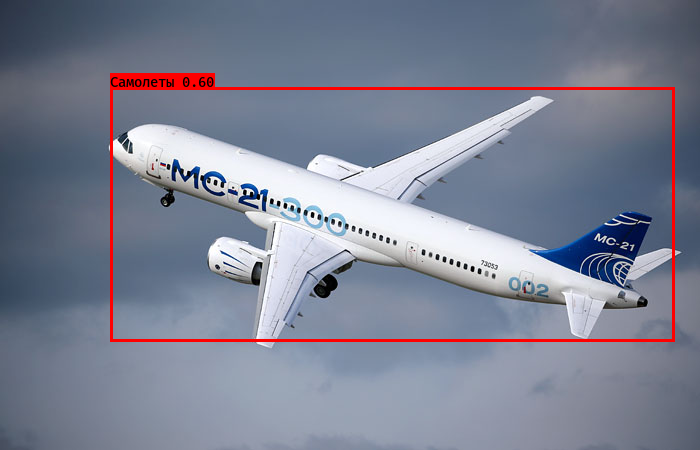

In [ ]:
yolo3_predict('Documents/ДЗ/31 Object detection/test/plane3.jpg', 'Documents/ДЗ/31 Object detection/my saves/short/full2.h5', box_limit=0.5)

Documents/ДЗ/31 Object detection/my saves/short/full2.h5 загружены.
Самолеты 0.94 (123, 38) (526, 269)


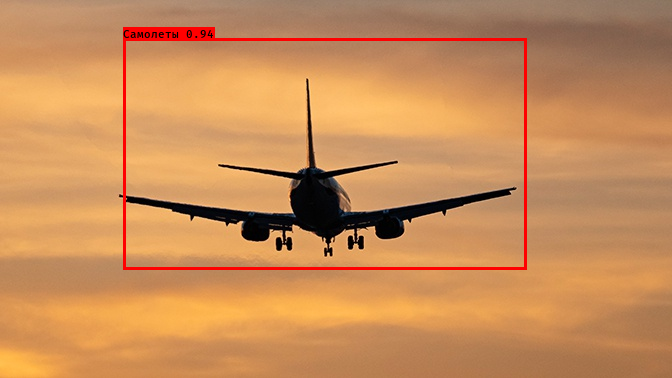

In [ ]:
yolo3_predict('Documents/ДЗ/31 Object detection/test/plane1.jpg', 'Documents/ДЗ/31 Object detection/my saves/short/full2.h5', box_limit=0.5)

### Графики

#### Первые 100 эпох

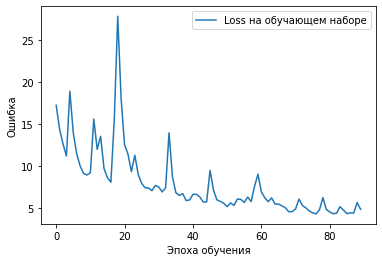

min: 4.346057415008545
last: 4.897207736968994


In [ ]:
# Первые 100 эпох
loss1 = pd.read_csv(path+'csv/YOLO/loss__el1000_opt0.001__ep0_100.csv')
values = loss1.values[:, 1]
plt.plot(values[10:100], 
         label='Loss на обучающем наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()
print ('min:', values.min())
print ('last:', values[-1])

#### 200 эпох

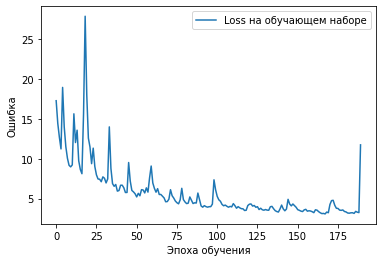

min: 3.07942271232605
last: 11.72924518585205


In [ ]:
# 200 эпох
loss2 = pd.read_csv(path+'csv/YOLO/loss__el1000_opt0.001__ep100_200.csv')
values2 = loss2.values[:, 1]
full_loss = np.concatenate((values, values2))
plt.plot(full_loss[10:], 
         label='Loss на обучающем наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()
print ('min:', full_loss.min())
print ('last:', full_loss[-1])

#### 300 эпох

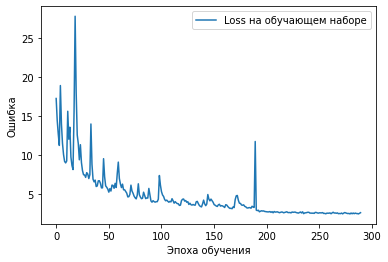

min: 2.412327766418457
last: 2.5681920051574707


In [ ]:
# 300 эпох
loss3 = pd.read_csv(path+'csv/YOLO/loss__el1000_opt0.0001__ep0_100.csv')
values3 = loss3.values[:, 1]
full_loss = np.concatenate((full_loss, values3))
plt.plot(full_loss[10:], 
         label='Loss на обучающем наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()
print ('min:', full_loss.min())
print ('last:', full_loss[-1])

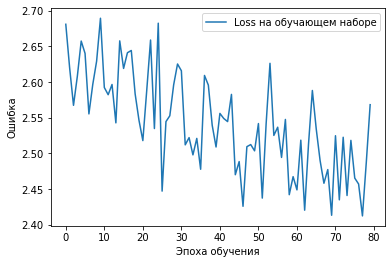

min: 2.412327766418457


In [ ]:
plt.plot(full_loss[-80:], 
         label='Loss на обучающем наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()
print ('min:', full_loss.min())

#### 400 эпох

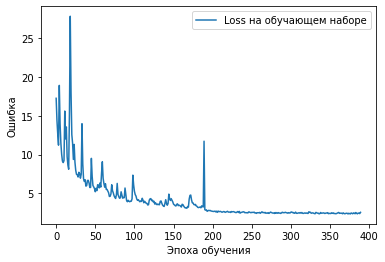

min: 2.3535728454589844
last: 2.558185577392578


In [ ]:
# 400 эпох
loss4 = pd.read_csv(path+'csv/YOLO/loss__el1000_opt0.0001__ep100_200.csv')
values4 = loss4.values[:, 1]
full_loss = np.concatenate((full_loss, values4))
plt.plot(full_loss[10:], 
         label='Loss на обучающем наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()
print ('min:', full_loss.min())
print ('last:', full_loss[-1])

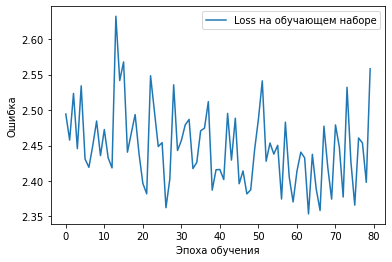

min: 2.3535728454589844
last: 2.558185577392578


In [ ]:
plt.plot(full_loss[-80:], 
         label='Loss на обучающем наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()
print ('min:', full_loss.min())
print ('last:', full_loss[-1])

#### 500 эпох

Пояснение: на дополнительных 500 эпохах локальная среда подустала и почему-то не осхранила данные ошибок. В итоге график похож, но минимальные значения loss показывает не с этого обучения.

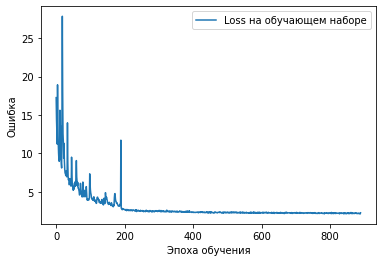

min: 2.1423819065093994
last: 2.2819204330444336


In [ ]:
# 500 эпох
loss5 = pd.read_csv(path+'csv/YOLO/loss__el1000_opt0.00001__ep0_100.csv')
values5 = loss5.values[:, 1]
full_loss = np.concatenate((full_loss, values5))
plt.plot(full_loss[10:], 
         label='Loss на обучающем наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()
print ('min:', full_loss.min())
print ('last:', full_loss[-1])

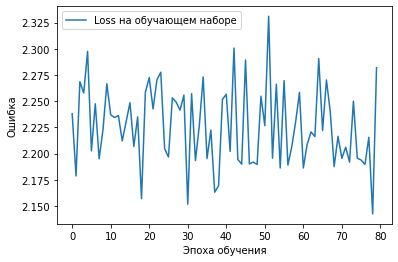

min: 2.1423819065093994
last: 2.2819204330444336


In [ ]:
plt.plot(full_loss[-80:], 
         label='Loss на обучающем наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()
print ('min:', full_loss.min())
print ('last:', full_loss[-1])

#### На тестовой выборке

In [ ]:
val_loss1 = pd.read_csv(path+'csv/YOLO/valloss__el1000_opt0.001__ep0_100.csv').values[:,1]
val_loss2 = pd.read_csv(path+'csv/YOLO/valloss__el1000_opt0.001__ep100_200.csv').values[:,1]
val_loss3 = pd.read_csv(path+'csv/YOLO/valloss__el1000_opt0.0001__ep0_100.csv').values[:,1]
val_loss4= pd.read_csv(path+'csv/YOLO/valloss__el1000_opt0.0001__ep100_200.csv').values[:,1]
val_loss5= pd.read_csv(path+'csv/YOLO/valloss__el1000_opt0.00001__ep0_100.csv').values[:,1]
print ('Ошибки на последней эпохе каждого шага:')
print ('100 эпох:', str(round(val_loss1[-1], 4)))
print ('210 эпох:', str(round(val_loss2[-1], 4)))
print ('300 эпох:', str(round(val_loss3[-1], 4)))
print ('400 эпох:', str(round(val_loss4[-1], 4)))
print ('500 эпох:', str(round(val_loss5[-1], 4)))

Ошибки на последней эпохе каждого шага:
100 эпох: 5.1383
210 эпох: 10.2438
300 эпох: 2.4625
400 эпох: 2.5926
500 эпох: 2.3488
